In [0]:
#@title Install dependencies
!git clone https://github.com/titu1994/keras-coordconv.git
!cp keras-coordconv/coord.py coord.py

!git clone https://github.com/zhixuhao/unet.git
!cp unet/model.py unet.py

!git clone https://github.com/zhixuhao/unet/
!ls

Cloning into 'keras-coordconv'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 201.64 KiB | 721.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.
Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (80/80), done.
fatal: destination path 'unet' already exists and is not an empty directory.
coord.py  keras-coordconv  sample_data	unet  unet.py


In [0]:
import tensorflow as tf
# tf.enable_eager_execution()

from keras import *
from coord import CoordinateChannel2D
from unet import unet

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import scipy
import random


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def get_training_data(self,datafolder):
        training_data = []
        filenames = os.listdir(datafolder)
        for filename in tqdm(filenames):
            path = os.path.join(datafolder,filename)
            image = Image.open(path)
            #Resizes to a desired size.
            image = image.resize((self.image_width,self.image_height),Image.ANTIALIAS)
            #Creates an array of pixel values from the image.
            pixel_array = np.asarray(image)

            training_data.append(pixel_array)

        #training_data is converted to a numpy array
        training_data = np.reshape(training_data,(-1,self.image_width,self.image_height,self.channels))
        return training_data
    


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = shape_x
        self.img_cols = shape_y
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.noise_size = 100


        optimizer = optimizers.Adadelta()
        loss = losses.mean_squared_logarithmic_error

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = build_generator(False,self.img_shape)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.img_shape))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss=loss, optimizer=optimizer)
        
    def build_generator(self):
        model = Sequential()

        model.add(Dense(256*4*4,activation="relu",input_dim=self.noise_size))
        model.add(Reshape((4,4,256)))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Activation("relu"))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Activation("relu"))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Activation("relu"))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Activation("relu"))


        model.add(Conv2D(self.channels,kernel_size=3,padding="same"))
        model.add(Activation("tanh"))

        input = Input(shape=(self.noise_size,))
        generated_image = model(input)
        return Model(input,generated_image)

    def build_discriminator(self):

        model = Sequential()

        img = Input(shape=self.img_shape)

        model = Sequential()
        model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.BatchNormalization(momentum=0.8))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))        

        validity = model(img)
        return Model(img, validity)

    def summary(self):
        self.generator.summary()
        self.discriminator.summary()
        
    def train(self, epochs, batch_size=128, sample_interval=50):

        # ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        
        with tqdm(range(epochs)) as pbar:
            for epoch in pbar:

                # Train Discriminator
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                imgs_x = x_train[idx]
                
                noise = np.random.normal(0,1,(batch_size,self.noise_size))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(imgs_x)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs_x, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                # Train Generator
                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(imgs_x, valid)

                # Plot the progress
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

                # If at save interval => save generated image samples
                if epoch % sample_interval == 0:
                    self.sample_images(epoch, imgs_x, imgs_y)

    def sample_images(self, epoch, imgs_x, imgs_y):
        r, c = 2, 2
        gen_imgs = self.generator.predict(imgs_x)
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs_x[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs_y[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
     

In [0]:
CE = GAN()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 17, 17, 128)       0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 17, 17, 128)       0         
__________

/content/unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [0]:
from keras.utils.vis_utils import plot_model

plot_model(CE.combined, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.477902]


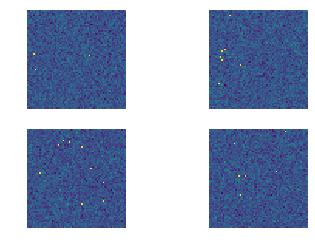

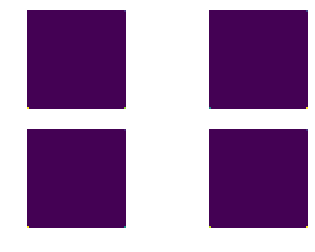

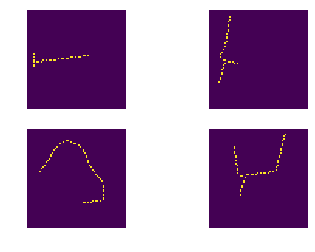

1 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478110]
2 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478135]
3 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.477956]
4 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478365]
5 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478266]
6 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478175]
7 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478007]
8 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478155]
9 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478157]
10 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478224]


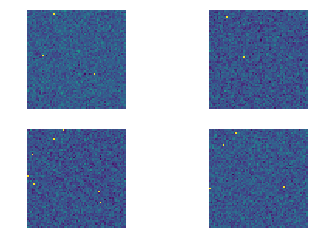

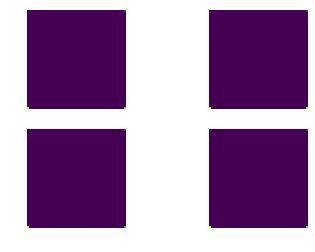

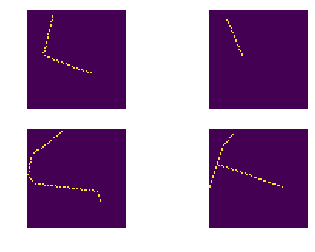

11 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478244]
12 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.478070]
13 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478090]
14 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478391]
15 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478345]
16 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478496]
17 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478224]
18 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478559]
19 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478408]
20 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478483]


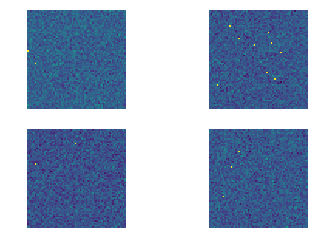

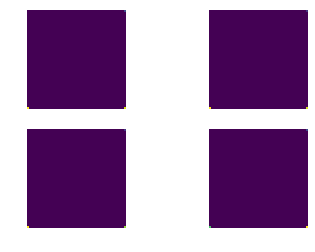

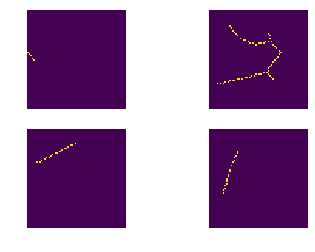

21 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478787]
22 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478480]
23 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.478445]
24 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478368]
25 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478516]
26 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478464]
27 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.478405]
28 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.478401]
29 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478322]
30 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478346]


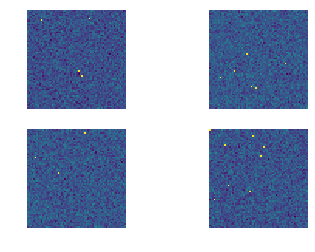

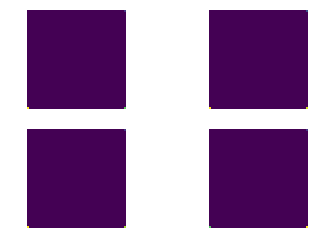

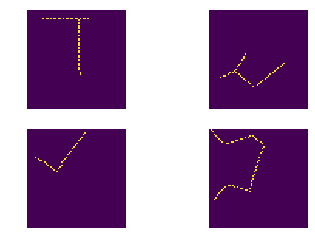

31 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.478460]
32 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478411]
33 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478468]
34 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.477990]
35 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.478068]
36 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.477962]



KeyboardInterrupt: ignored

In [0]:
epochs = 300  #@param{type: 'integer'}
batch_size = 64  #@param{type: 'integer'}
sample_interval = 100  #@param{type: 'integer'}

CE.train(epochs=30000, batch_size=64, sample_interval=10)

We first need to turn the coordinates to images that can be fed into  a CNN